## **Sequoia Image Processing**
This notebook is built from https://github.com/rasmusfenger/micasense_imageprocessing_sequoia, which includes added functionality to the Micasense RedEdge image processing open library to enable Sequoia image processing.

### **Opening the raw image with pyplot**
Open the panel image with pyplot. Sequoia 16-bit images can be read directly into numpy arrays using the pyplot imread function and then displayed inline using the imshow function.

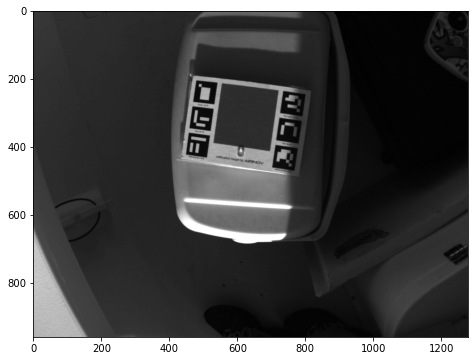

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os,glob
import math
import exiftool
import rasterio
from GPSPhoto import gpsphoto
import gdal
from osgeo.gdal import GetDriverByName, GDT_UInt16
import cameratransform as ct
%matplotlib inline

imagePath = os.path.join('.','data','Sequoia','200717areaaPM01','0013')
imageName = os.path.join(imagePath,'IMG_200717_110955_0000_RED.TIF')

# Read raw image DN values
# reads 16 bit tif - this will likely not work for 12 bit images
imageRaw=plt.imread(imageName)

# Display the image
fig, ax = plt.subplots(figsize=(8,6))
ax.imshow(imageRaw, cmap='gray')
plt.show()

### **Adding a colorbar**
Using the plotting function in micasense.plotutils that adds a colorbar to the display to see changes in the values and the range of values more easily after various conversions. This function colorizes the grayscale images.

<Figure size 432x288 with 0 Axes>

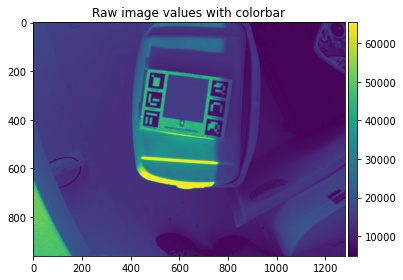

In [2]:
import micasense.plotutils as plotutils

# Optional: pick a color map that fits your viewing style
# one of 'gray, viridis, plasma, inferno, magma, nipy_spectral'
plotutils.colormap('viridis')

plotutils.plotwithcolorbar(imageRaw, title='Raw image values with colorbar');

### **Reading Sequoia Metadata**
Using Exiftool to read the metadata of an image, including standard image capture data (location,  UTC time, imager exposure, and gain), as well as Sequoia specific metadata

In [3]:
import micasense.metadata as metadata
from datetime import datetime, timedelta

exiftoolPath = None
if os.name == 'nt':
    exiftoolPath = 'C:/exiftool/exiftool.exe'
# get image metadata
meta = metadata.Metadata(imageName, exiftoolPath=exiftoolPath)
cameraMake = meta.get_item('EXIF:Make')
cameraModel = meta.get_item('EXIF:Model')
firmwareVersion = meta.get_item('EXIF:Software')
bandName = meta.get_item('XMP:BandName')
lat = meta.get_item('EXIF:GPSLatitude')
latref = meta.get_item('EXIF:GPSLatitudeRef')
lon = meta.get_item('EXIF:GPSLongitude')
lonref = meta.get_item('EXIF:GPSLongitudeRef')
alt = meta.get_item('EXIF:GPSAltitude')
str_time = meta.get_item('EXIF:DateTimeOriginal')
utc_time = datetime.strptime(str_time, "%Y:%m:%d %H:%M:%S")
fp_x_resolution = meta.get_item('EXIF:FocalPlaneXResolution')
fp_y_resolution = meta.get_item('EXIF:FocalPlaneYResolution')

print('{0} {1} firmware version: {2}'.format(cameraMake, 
                                             cameraModel, 
                                             firmwareVersion))
print('Exposure Time: {0} seconds'.format(meta.get_item('EXIF:ExposureTime')))
print('Imager Gain: {0}'.format(meta.get_item('EXIF:ISO')/100.0))
print('Size: {0}x{1} pixels'.format(meta.get_item('EXIF:ImageWidth'),meta.get_item('EXIF:ImageHeight')))
print('Band Name: {0}'.format(bandName))
print('Center Wavelength: {0} nm'.format(meta.get_item('XMP:CentralWavelength')))
print('Bandwidth: {0} nm'.format(meta.get_item('XMP:WavelengthFWHM')))
print('Focal Length: {0}'.format(meta.get_item('EXIF:FocalLength')))
print('GPS Latitude: {0}'.format(meta.get_item('EXIF:GPSLatitude')))
print('GPS Latitude Ref: {0}'.format(meta.get_item('EXIF:GPSLatitudeRef')))
print('GPS Longitude: {0}'.format(meta.get_item('EXIF:GPSLongitude')))
print('GPS Longitude Ref: {0}'.format(meta.get_item('EXIF:GPSLongitudeRef')))
print('GPS Altitude: {0}'.format(meta.get_item('EXIF:GPSAltitude')))
print('GPS Altitude Ref: {0}'.format(meta.get_item('EXIF:GPSAltitudeRef')))
print('Str Time: {0}'.format(meta.get_item('EXIF:DateTimeOriginal')))
print('UTC Time:', utc_time)
print('Focal Plane X Resolution: {0} mm'.format(meta.get_item('EXIF:FocalPlaneXResolution')))
print('Focal Plane Y Resolution: {0} mm'.format(meta.get_item('EXIF:FocalPlaneYResolution')))

Parrot Sequoia firmware version: v1.7.2
Exposure Time: 0.000415384304 seconds
Imager Gain: 1.0
Size: 1280x960 pixels
Band Name: Red
Center Wavelength: 660.0 nm
Bandwidth: 40.0 nm
Focal Length: 3.979999908
GPS Latitude: 34.6625164277806
GPS Latitude Ref: N
GPS Longitude: 76.6683351000472
GPS Longitude Ref: W
GPS Altitude: 0.6127272251
GPS Altitude Ref: 0
Str Time: 2020:07:17 11:09:55
UTC Time: 2020-07-17 11:09:55
Focal Plane X Resolution: 266.6666559 mm
Focal Plane Y Resolution: 266.6666559 mm


### **Converting raw Sequoia images to irradiance** 
This step includes vignette correction and conversion of raw image to irradiance using the sensor calibration model.

First a vignette map is created following the procedure described in the [Application Note: How to correct vignetting in images](https://forum.developer.parrot.com/uploads/default/original/2X/b/b9b5e49bc21baf8778659d8ed75feb4b2db5c45a.pdf) The implemented code is written by [seanmcleod](https://forum.developer.parrot.com/t/vignetting-correction-sample-code/5614). The vignette map will be multiplied by the raw image values to reverse the darkening seen at the image corners. See the vignette_correction function for the details of the vignette parameters and their use.

    V = vignette_correction(meta, xDim, yDim)
The conversion of raw image to irradiance is done following the procedure described in the [Application note: Pixel value to irradiance using the sensor calibration model](https://forum.developer.parrot.com/uploads/default/original/2X/3/383261d35e33f1f375ee49e9c7a9b10071d2bf9d.pdf). The procedure is described in more details in this [document](https://onedrive.live.com/?authkey=%21ACzNLk1ORe37aRQ&cid=C34147D823D8DFEF&id=C34147D823D8DFEF%2115414&parId=C34147D823D8DFEF%21106&o=OneUp).

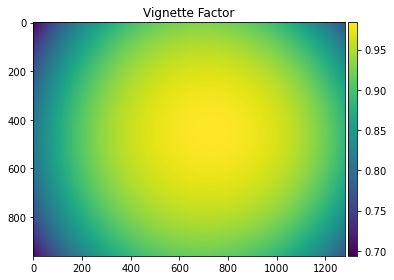

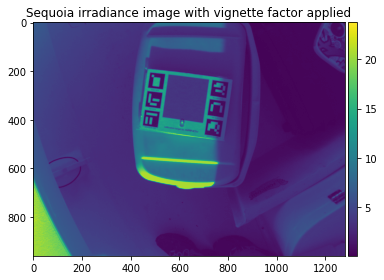

In [4]:
import micasense.plotutils as plotutils
import micasense.sequoiautils as msutils
SequoiaIrradiance, V = msutils.sequoia_irradiance(meta, imageRaw)
plotutils.plotwithcolorbar(V,'Vignette Factor');
plotutils.plotwithcolorbar(SequoiaIrradiance,'Sequoia irradiance image with vignette factor applied');

### **Sunshine calibration of Sequoia irradiance image**
Next step is to calculate the sunshine irradiance. This is used to normalise the images in an image dataset according to variations in the incomming solar radiation. The implemented code for retrieving the sunshine sensor data is written by [Yu-Hsuan Tu](https://github.com/dobedobedo/Parrot_Sequoia_Image_Handler/tree/master/Modules/Dependency).


Sunshine sensor irradiance:  9.22


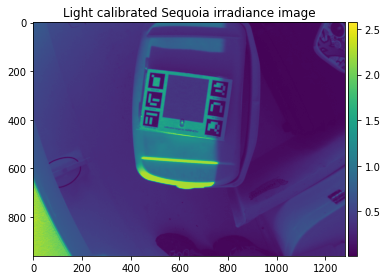

In [5]:
# Sunshine sensor Irradiance
SunIrradiance = msutils.GetSunIrradiance(meta)
print ('Sunshine sensor irradiance: ', SunIrradiance)

# Light calibrated sequoia irradiance
SequoiaIrradianceCalibrated = SequoiaIrradiance/SunIrradiance
plotutils.plotwithcolorbar(SequoiaIrradianceCalibrated,'Light calibrated Sequoia irradiance image');

### **Convert irradiance to reflectance**
The calibrated irradiance image can now be converted into reflectance. To do this, an image of a reflectance panel with known reflectance is required. The irradiance values of the panel image is then used to determine a scale factor between irradiance and reflectance.
In this case, we have our MicaSense calibrated reflectance panel and it's known reflectance of 68% in the band of interest (19.7% in the Sequoia calibration panel). We will extract the area of the image containing the lambertian panel, determine it's irradiance to reflectance scale factor, and then scale the whole image by that factor to get a reflectance image.

For the Parrot Sequoia sensor, Reflectance = K * Isq/Iss where Isq is sensor irradiance and Iss is sunshine irradiance. K is determined by the calibration target, K = Rref * Iss/Isq, where Rref is the known reflectance of the panel and Iss and Isq are irradiances of the panel image. K is the calibration coefficient that relates the ratio of sequoia irradiance to sunshine irradiance.

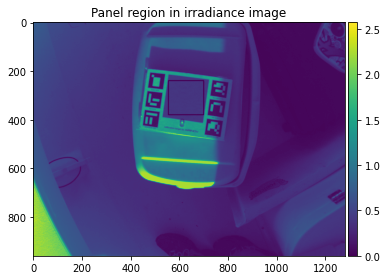

Mean Irradiance in panel region: 0.397 W/m^2/nm/sr
Irradiance to reflectance conversion factor: 0.496


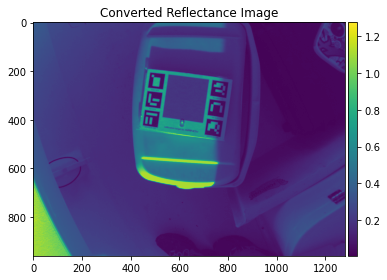

In [6]:
markedImg = SequoiaIrradianceCalibrated.copy()
ulx = 555 # upper left column (x coordinate) of panel area
uly = 240 # upper left row (y coordinate) of panel area
lrx = 700 # lower right column (x coordinate) of panel area
lry = 380 # lower right row (y coordinate) of panel area
cv2.rectangle(markedImg,(ulx,uly),(lrx,lry),(0,255,0),3)

# Our panel calibration by band 
# sequoia specific panel
panelCalibration = { 
    "Green": 0.189, 
    "Red": 0.197, 
    "Red edge": 0.221, 
    "NIR": 0.255 
}
# micasense specific panel
#panelCalibration = { 
    #"Green": 0.69, 
    #"Red": 0.68, 
    #"Red edge": 0.67, 
    #"NIR": 0.61 
#}
# Select panel region from irradiance image
panelRegion = SequoiaIrradianceCalibrated[uly:lry, ulx:lrx]
plotutils.plotwithcolorbar(markedImg, 'Panel region in irradiance image')

#panel irradiance = sequoia irradiance / sunshine irradiance 
meanIrradiance = panelRegion.mean()
print('Mean Irradiance in panel region: {:1.3f} W/m^2/nm/sr'.format(meanIrradiance))
panelReflectance = panelCalibration[bandName]

# K = Rref * (Iss/Isq), or Rref / (Isq/Iss)
irradianceToReflectance = panelReflectance / meanIrradiance
print('Irradiance to reflectance conversion factor: {:1.3f}'.format(irradianceToReflectance))

# R = K * (Isq/Iss)
reflectanceImage = SequoiaIrradianceCalibrated * irradianceToReflectance
plotutils.plotwithcolorbar(reflectanceImage, 'Converted Reflectance Image');

Now we will extract the same region and verify the reflectance in that region is what we expect. In the process, we will blur and visualize the extracted area to look for any trends. The area should have a very consistent reflectance. If a gradient or a high standard deviation (>3% absolute reflectance) is noticed across the panel area it is possible that the panel was captured under inconsistent lighting conditions (e.g. next to a wall or vehicle) or it was captured too close to the edge of the image where the optical calibration is the least accurate.

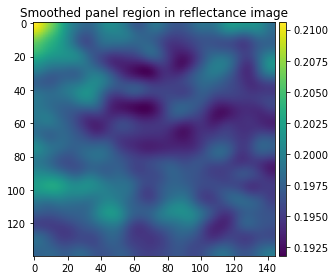

Min Reflectance in panel region: 0.17
Max Reflectance in panel region: 0.29
Mean Reflectance in panel region: 0.20
Standard deviation in region: 0.0096


In [7]:
panelRegionRaw = imageRaw[uly:lry, ulx:lrx]
panelRegionRefl = reflectanceImage[uly:lry, ulx:lrx]
panelRegionReflBlur = cv2.GaussianBlur(panelRegionRefl,(55,55),5)
plotutils.plotwithcolorbar(panelRegionReflBlur, 'Smoothed panel region in reflectance image')
print('Min Reflectance in panel region: {:1.2f}'.format(panelRegionRefl.min()))
print('Max Reflectance in panel region: {:1.2f}'.format(panelRegionRefl.max()))
print('Mean Reflectance in panel region: {:1.2f}'.format(panelRegionRefl.mean()))
print('Standard deviation in region: {:1.4f}'.format(panelRegionRefl.std()))

### **Undistorting images**
Lens distortion effects can be removed from the image using the information in [Application Note: how to correct distortion in images](https://forum.developer.parrot.com/uploads/default/original/2X/e/ec302e9e4498cba5165711c2a52fa2c37be10431.pdf). The implemented code is originally written in Matlab by [muzammil360](https://github.com/muzammil360/SeqUDR) and has been modified and rewritten in Python.

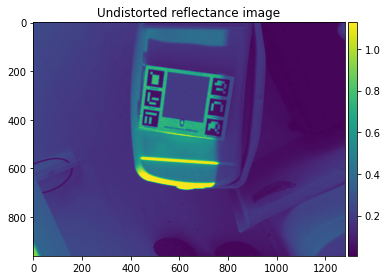

In [8]:
# correct for lens distortions to make straight lines straight
undistortedReflectance = msutils.correct_lens_distortion_sequoia(meta, reflectanceImage)
plotutils.plotwithcolorbar(undistortedReflectance, 'Undistorted reflectance image');

### **Converting raw flight images to reflectance based on the ```irradiancetoReflectance``` value above**

#### **Sample image**

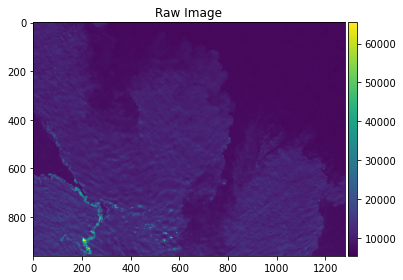

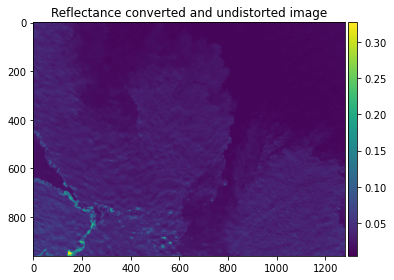

In [9]:
imagePath = os.path.join('.','data','Sequoia','200717areaaPM01','0016')
flightImageName = os.path.join(imagePath,'IMG_200717_111918_0116_RED.TIF')
flightImageRaw=plt.imread(flightImageName)
plotutils.plotwithcolorbar(flightImageRaw, 'Raw Image')

flightImageMeta = metadata.Metadata(flightImageName, exiftoolPath=exiftoolPath)

SequoiaIrradiance, V = msutils.sequoia_irradiance(flightImageMeta, flightImageRaw)
# Sunshine sensor Irradiance
SunIrradiance = msutils.GetSunIrradiance(flightImageMeta)
# Light calibrated sequoia irradiance
SequoiaIrradianceCalibrated = SequoiaIrradiance/SunIrradiance
flightReflectanceImage = SequoiaIrradianceCalibrated * irradianceToReflectance
flightUndistortedReflectance = msutils.correct_lens_distortion_sequoia(flightImageMeta, flightReflectanceImage)
plotutils.plotwithcolorbar(flightUndistortedReflectance, 'Reflectance converted and undistorted image');

In [10]:
np.max(flightUndistortedReflectance),np.min(flightUndistortedReflectance),np.mean(flightUndistortedReflectance)

(0.32719287, 0.004808822, 0.026621938)

(array([1.64776e+05, 2.29804e+05, 1.60689e+05, 2.33685e+05, 2.19605e+05,
        1.18118e+05, 4.94670e+04, 2.31880e+04, 1.12200e+04, 5.22100e+03,
        2.93400e+03, 1.66700e+03, 1.10300e+03, 8.14000e+02, 7.22000e+02,
        6.26000e+02, 5.51000e+02, 4.54000e+02, 4.32000e+02, 3.76000e+02,
        3.99000e+02, 3.53000e+02, 3.08000e+02, 2.77000e+02, 2.61000e+02,
        2.24000e+02, 2.02000e+02, 1.79000e+02, 1.44000e+02, 1.32000e+02,
        9.40000e+01, 1.02000e+02, 7.40000e+01, 7.20000e+01, 6.60000e+01,
        3.20000e+01, 5.70000e+01, 3.60000e+01, 3.60000e+01, 3.00000e+01,
        2.20000e+01, 2.10000e+01, 2.10000e+01, 1.90000e+01, 3.00000e+01,
        3.30000e+01, 1.50000e+01, 1.70000e+01, 2.00000e+01, 7.20000e+01]),
 array([0.00480882, 0.0112565 , 0.01770419, 0.02415187, 0.03059955,
        0.03704723, 0.04349491, 0.04994259, 0.05639027, 0.06283795,
        0.06928563, 0.07573331, 0.08218099, 0.08862867, 0.09507636,
        0.10152404, 0.10797172, 0.1144194 , 0.12086708, 0.127314

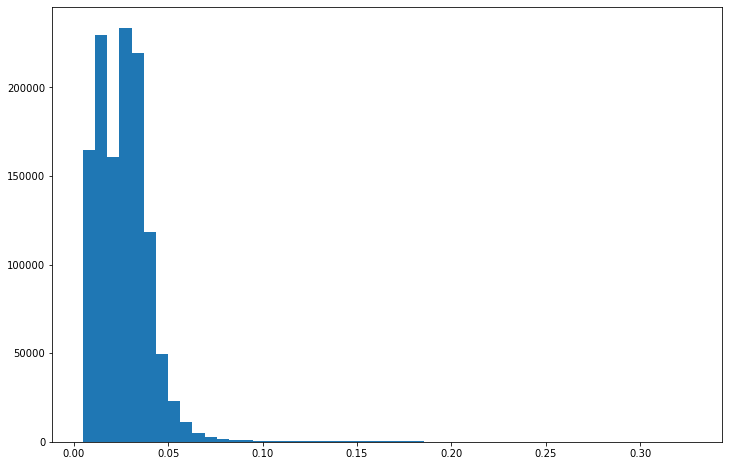

In [11]:
#plot histogram of reflectance values
fig, ax = plt.subplots(figsize=(12,8))

ax.hist(flightUndistortedReflectance.flatten(), bins=50,)

### **Reflectance to turbidity**
Turbidity can be calculated from reflectance values in the Red or NIR band using [A single algorithm to retrieve turbidity from remotely-sensed data in all coastal and estuarine waters](https://reader.elsevier.com/reader/sd/pii/S0034425714003654?token=749929E5DF7F12BBA191B38CB0C4A2DCD313AA0B664D157DC9FE59332F84198F272C69B1668301F913B7BB1E5078A4E6) where T = a*Pw/(1-Pw/c). Pw is defined as the marine reflectance and is equal to pi*Lw/Ed. Lw is defined as the water-leaving radiance and Ed is the downwelling radiance. Sequoia irradiance is equal to pi*Lw, so the equation can be rewritten to Pw = water-leaving irradiance / downwelling irradiance. 

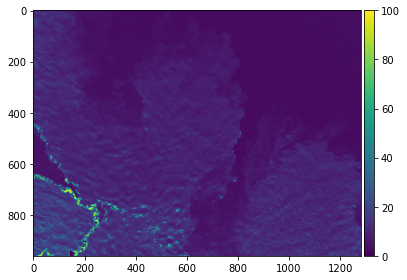

In [12]:
#single band turbidity analysis algorithm in the red band 
#turbidity = (a * Pw) /(1-Pw / c)
#Pw = water leaving reflectance 
#a and c are two wavelength-dependent calibration coefficients 
a = 254.67
c = 0.1705

turbidity = a * flightUndistortedReflectance / (1 - flightUndistortedReflectance / c)
turbidity[turbidity < 0] = 0
turbidity[turbidity > 100] = 100
plotutils.plotwithcolorbar(turbidity);

In [13]:
np.max(turbidity), np.min(turbidity), np.mean(turbidity)

(100.0, 0.0, 8.548026)

In [14]:
turbidity.shape

(960, 1280)

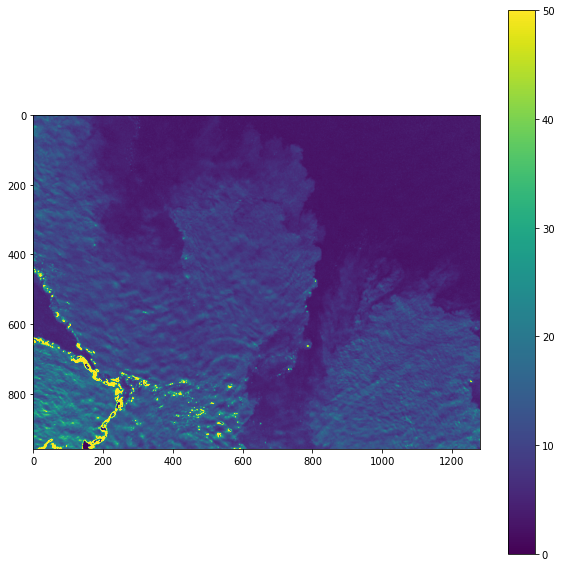

In [15]:
#plot with colorbar
fig, ax = plt.subplots(figsize=(10,10))
#im = ax.imshow(np.reshape(turbidity,(960, 1280)), vmin=0, vmax=30, cmap='jet')
im = ax.imshow(turbidity, vmin=0, vmax=50, cmap='viridis')
fig.colorbar(im)
plt.savefig('turbidity_red_ex.tif')

(-0.5, 1279.5, 959.5, -0.5)

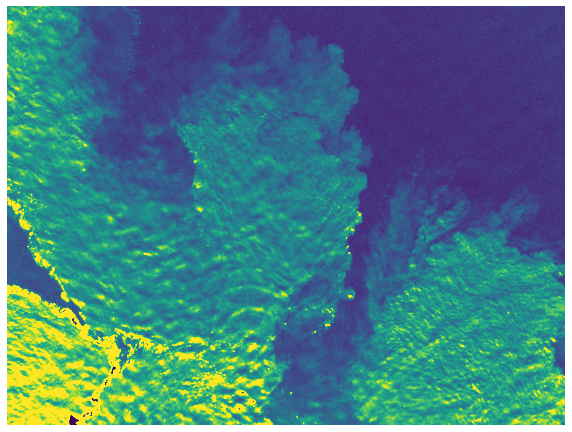

In [16]:
#plot without colorbar 
fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(turbidity, vmin=0, vmax=20)
plt.axis('off')
#fig.savefig('turbidity_91_nocmbar.tif', bbox_inches='tight', pad_inches=0)

(array([5.50400e+03, 3.00480e+05, 1.61358e+05, 1.66633e+05, 2.07746e+05,
        1.64923e+05, 9.64600e+04, 4.86850e+04, 2.60610e+04, 1.55620e+04,
        9.79100e+03, 6.13800e+03, 3.85000e+03, 2.57500e+03, 1.81100e+03,
        1.43000e+03, 9.87000e+02, 7.74000e+02, 6.07000e+02, 4.89000e+02,
        4.39000e+02, 3.39000e+02, 2.96000e+02, 2.43000e+02, 2.50000e+02,
        2.08000e+02, 1.82000e+02, 1.66000e+02, 1.65000e+02, 1.42000e+02,
        1.68000e+02, 1.48000e+02, 1.15000e+02, 1.24000e+02, 1.30000e+02,
        1.08000e+02, 9.30000e+01, 9.40000e+01, 9.60000e+01, 8.50000e+01,
        7.70000e+01, 7.70000e+01, 8.80000e+01, 6.60000e+01, 6.50000e+01,
        4.70000e+01, 5.10000e+01, 6.40000e+01, 6.00000e+01, 2.75000e+03]),
 array([  0.,   2.,   4.,   6.,   8.,  10.,  12.,  14.,  16.,  18.,  20.,
         22.,  24.,  26.,  28.,  30.,  32.,  34.,  36.,  38.,  40.,  42.,
         44.,  46.,  48.,  50.,  52.,  54.,  56.,  58.,  60.,  62.,  64.,
         66.,  68.,  70.,  72.,  74.,  76.,  7

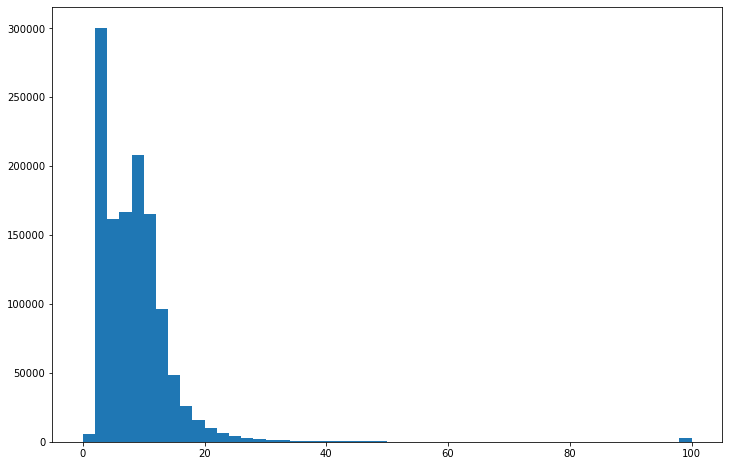

In [17]:
#plot histogram of turbidity values 
fig, ax = plt.subplots(figsize=(12,8))

ax.hist(turbidity.flatten(), bins=50,)

### **Save all turbidity outputs as png files with a colorbar**
Save the turbidity outputs as individual images to use a "spot samples". Change the "turbidity" minimum and maximum values based on visualization needs. 

In [18]:
#inputPath = os.path.join('.','data','Sequoia','200717areaaPM01','0016')
#outputPath = os.path.join('.','data','Sequoia','200717areaaPM01','0016','Turbidity')

#a = 366.14
#c = 0.19563

#for filename in os.listdir(inputPath):
    #if filename.endswith("NIR.TIF"):
        #imageName = os.path.join(inputPath, filename)
        #flightImageRaw=plt.imread(imageName)
        #flightImageMeta = metadata.Metadata(imageName, exiftoolPath=exiftoolPath)
        #SequoiaIrradiance, _ = msutils.sequoia_irradiance(flightImageMeta, flightImageRaw)
        #SunIrradiance = msutils.GetSunIrradiance(flightImageMeta)
        #SequoiaIrradianceCalibrated = SequoiaIrradiance/SunIrradiance
        #flightReflectanceImage = SequoiaIrradianceCalibrated * radianceToReflectance
        #flightUndistortedReflectance = msutils.correct_lens_distortion_sequoia(flightImageMeta, flightReflectanceImage)
        #turbidity = (a*flightUndistortedReflectance) / (1 - flightUndistortedReflectance / c)
        #change these values below to adjust the colorbar scale
        #turbidity[turbidity < 0] = 0
        #turbidity[turbidity > 50] = 50
        #fig, ax = plt.subplots(figsize=(10,10))
        #im = ax.imshow(turbidity, vmin=0, vmax=50, cmap='viridis')
        #fig.colorbar(im)
        #outputname = filename.split('.')[0] + '_sample' + '.png'
        #plt.savefig(outputname, format='png')

## **Converting all Sequoia images to reflectance and turbidity**

### **Helper functions**
Adapted from https://github.com/marrs-lab/drone_ocean_color

In [18]:
def decdeg2dms(dd):
    is_positive = dd >= 0
    dd = abs(dd)
    minutes,seconds = divmod(dd*3600,60)
    degrees,minutes = divmod(minutes,60)
    degrees = degrees if is_positive else -degrees
    return (degrees,minutes,seconds)

def write_exif_csv(inputPath, outputPath):
    header = "SourceFile,\
        GPSDateStamp,GPSTimeStamp,\
        GPSLatitude,GPSLatitudeRef,\
        GPSLongitude,GPSLongitudeRef,\
        GPSAltitude,GPSAltitudeRef,\
        FocalLength,\
        XResolution,YResolution,ResolutionUnits\n"
    lines = [header]
    for filename in os.listdir(inputPath):
        if filename.endswith("RED.TIF"):
            imageName = os.path.join(inputPath, filename)
            fullOutputPath = os.path.join(outputPath, filename)
            meta = metadata.Metadata(imageName, exiftoolPath=exiftoolPath)
            lat = meta.get_item('EXIF:GPSLatitude')
            latref = meta.get_item('EXIF:GPSLatitudeRef')
            lon = meta.get_item('EXIF:GPSLongitude')
            lonref = meta.get_item('EXIF:GPSLongitudeRef')
            alt = meta.get_item('EXIF:GPSAltitude')
            fp_x_resolution = meta.get_item('EXIF:FocalPlaneXResolution')
            fp_y_resolution = meta.get_item('EXIF:FocalPlaneYResolution')
            focal_length = meta.get_item('EXIF:FocalLength')
            str_time = meta.get_item('EXIF:DateTimeOriginal')
            if str_time is not None:
                utc_datetime = datetime.strptime(str_time, "%Y:%m:%d %H:%M:%S")
            if lat is not None:
                latdeg, latmin, latsec = decdeg2dms(lat)
                londeg, lonmin, lonsec = decdeg2dms(lon)
                latdir = 'North'
                if latdeg < 0:
                    latdeg = -latdeg
                    latdir = 'South'
                londir = 'West'
                if londeg < 0:
                    londeg = -londeg
                    londir = 'East'

                linestr = '"{}",'.format(fullOutputPath)
                linestr += utc_datetime.strftime("%Y:%m:%d,%H:%M:%S,")
                linestr += '"{:d} deg {:d}\' {:.2f}"" {}",{},'.format(int(latdeg),int(latmin),latsec,latdir[0],latdir)
                linestr += '"{:d} deg {:d}\' {:.2f}"" {}",{},{:.1f} m Above Sea Level,Above Sea Level,'.format(int(londeg),int(lonmin),lonsec,londir[0],londir,alt)
                linestr += '"{}",'.format(meta.get_item('EXIF:FocalLength'))
                linestr += '{},{},mm'.format(fp_x_resolution,fp_x_resolution)
                linestr += '\n'
                lines.append(linestr)
        
    fullCsvPath = os.path.join(outputPath,'log.csv')
    with open(fullCsvPath, 'w') as csvfile:
        csvfile.writelines(lines)
    
    return(fullCsvPath)

In [19]:
def array2raster(output, dataset, array, coords):
    image_size = (1280,960)
    gcp1 = rasterio.control.GroundControlPoint(row=0, col=0, x=coords[0,1], y=coords[0,0], z=coords[0,2], id=None, info=None)
    gcp2 = rasterio.control.GroundControlPoint(row=image_size[0]-1, col=0, x=coords[1,1], y=coords[1,0], z=coords[1,2], id=None, info=None)
    gcp3 = rasterio.control.GroundControlPoint(row=image_size[0]-1, col=image_size[1]-1, x=coords[2,1], y=coords[2,0], z=coords[2,2], id=None, info=None)
    gcp4 = rasterio.control.GroundControlPoint(row=0, col=image_size[1]-1, x=coords[3,1], y=coords[3,0], z=coords[3,2], id=None, info=None)

    with rasterio.Env():
        with rasterio.open(dataset, 'r') as src:
            profile = src.profile

        #tsfm = rasterio.transform.from_gcps([gcp1,gcp2,gcp3,gcp4])
        tsfm = rasterio.warp.calculate_default_transform(rasterio.crs.CRS({"init": "epsg:4326"}), rasterio.crs.CRS({"init": "epsg:4326"}), array.shape[0], array.shape[1], left=None, bottom=None, right=None, top=None, gcps=[gcp1,gcp2,gcp3,gcp4], resolution=None, dst_width=None, dst_height=None)
        tsfm = tsfm[0]
        crs = rasterio.crs.CRS({"init": "epsg: 4326"})
        profile.update(
            dtype=rasterio.uint8,
            transform = tsfm,
            crs=crs)
        with rasterio.open(output, 'w', **profile) as dst:
            dst.write(array.astype(rasterio.uint8), 1)

In [20]:
def save_reflectance_imgs (outfilename, array, photometric='MINISBLACK'):
    cols = array.shape[1]
    rows = array.shape[0]
    driver = gdal.GetDriverByName('GTiff')
    if array.ndim == 2:
        band_num = 1
    else:
        band_num = array.shape[2]
    outRaster = driver.Create(outfilename, cols, rows, band_num, GDT_UInt16, options = ['INTERLEAVE=BAND', 'COMPRESS=DEFLATE',f'PHOTOMETRIC={photometric}' ])
    # Loop over all bands.
    for b in range(band_num):
        outband = outRaster.GetRasterBand(b + 1)
        # Read in the band's data into the third dimension of our array
        if band_num == 1:
            outband.WriteArray(array*32768)
        else:
            outband.WriteArray(array[:,:,b])
    outband.FlushCache()
    outRaster = None
    

In [21]:
def load_img_fn_and_meta(img_dir, count, start):
    i = 0
    j= 0
    if not count:
        count = 10000
    img_metadata = []
    imgs = []
    for file in glob.glob(img_dir + "/*.TIF"):
        if j >= count:
            pass
        elif i < start:
            pass
        else:
            imgs.append(file)
            img_metadata.append(gpsphoto.getGPSData(file))
            j += 1
        i += 1
    return(imgs, img_metadata)

In [22]:
def load_images(img_list):
    all_imgs = []
    for im in img_list:
        with rasterio.open(im, 'r') as src:
            all_imgs.append(src.read())
    return(all_imgs)

In [23]:
def retrieve_imgs_and_metadata(img_dir, count=None, start=0):
    img_fns, img_metadata = load_img_fn_and_meta(img_dir, count=count, start=start)
    imgs = load_images(img_fns)
    imgs = np.array(imgs) / 32768
    print('Output shape is: ', imgs.shape)
    return(imgs, img_metadata)

In [24]:
def calculate_spectra_from_darkest_px(imgs, lowest_percent=0.65, band=1, return_imgs=False, visualize=False):
    list_of_spectra = []
    sorted_img_list = []
    dark_idxs = []
    
    for i in range(0,imgs.shape[0]):
        spectra = []
        num_to_sort = int(imgs[i,band].size * lowest_percent)
        
        flat_array = imgs[i,band].flatten()
        flat_array[flat_array == 0] = 1
        flat_array[flat_array < 0.0001 ] = 1
        idx = np.argpartition(flat_array, num_to_sort)[:num_to_sort]
        
        img_sorted = []
        for img_idx in range(0,1):
            sorted_band = imgs[i,img_idx].flatten()
            if return_imgs:
                img_sorted.append(sorted_band)
            #mean of darkest pixels from each band and append to spectra
            spectra.append(np.mean(sorted_band[idx]))
            spectra.append(np.median(sorted_band[idx]))
            spectra.append(np.min(sorted_band[idx]))
            spectra.append(np.max(sorted_band[idx]))
            #if img_idx == 0:
                #spectra.append(np.mean(sorted_band[idx]))
        if return_imgs:
            sorted_img_list.append(np.array(img_sorted))
        list_of_spectra.append(spectra)
        dark_idxs.append(i)
        
        if visualize:
            plt.hist(flat_array[idx], density=False)
            plt.axvline(x=np.mean(flat_array[idx]), color='red')
            plt.axvline(x=np.median(flat_array[idx]), color='black')
            print(i, np.median(flat_array[idx]))
        
    if return_imgs:
        return(sorted_img_list, idx)
    else:
        return(list_of_spectra, dark_idxs)    

In [25]:
def remove_bright_pix(im, lowest_percent=0.05, band=0):
    sorted_imgs, lowest_idx = calculate_spectra_from_darkest_px(np.array([im]), lowest_percent=lowest_percent, band=0, return_imgs=True)
    
    dark_pix = np.zeros(np.array(sorted_imgs[0]).shape)
    dark_pix[:,lowest_idx] = sorted_imgs[0][:,lowest_idx]
    
    dark_pix[dark_pix < 0.0005] = 0
    dark_pix[dark_pix > 1] = 0
    dark_pix[dark_pix == 0] = np.nan
    
    return(dark_pix)

In [26]:
def turbidity_img(dark_pix, wind_speed=5):
    a = 254.67
    c = 0.1705
    dp_shape = dark_pix.shape
    #sky_rad = np.reshape(np.array(sky_spectra) * (0.0256 + 0.00039 * wind_speed + 0.000034 * wind_speed * wind_speed), (1,1))
    #water_leaving = dark_pix.reshape(1,-1) - sky_rad
    dark_pix_dark = dark_pix.reshape(1,-1)
    turbidity = a * dark_pix_dark / (1 - dark_pix_dark / c)
    #turbidity[turbidity < 0] = 0
    #turbidity[turbidity > 100] = 0
    return(turbidity.reshape(dp_shape[1:3]))

In [56]:
def visualize_darkest_pixels(im, lowest_percent=0.5, only_img=False):
    band_names = ['red']
    colors = ['red']
    
    fig, ax = plt.subplots(figsize=(16,14))
    
    ims = ax.imshow(im[0], cmap='jet', vmax=0.2, vmin=0)
    ax.set_title(band_names[0])
    fig.colorbar(ims, fraction=0.046, pad=0.04)
    ax.set_xticks([])
    ax.set_yticks([])
        
    fig.show()
    
    if not only_img:
        dark_pix = remove_bright_pix(im, lowest_percent=lowest_percent, band=0)
        
        fig, ax = plt.subplots(figsize=(16,14))
    
        ims = ax.imshow(dark_pix[0].reshape(im.shape[1:3]), interpolation='none', cmap='jet', vmax=0.2, vmin=0)
        ax.set_title(band_names[0])
        fig.colorbar(ims, ax=ax, fraction=0.046, pad=0.04)
        ax.set_xticks([])
        ax.set_yticks([])
        fig.show()
        
        fig, ax = plt.subplots(figsize=(12,8))
        ax.hist(dark_pix[0].flatten(), density=True, bins=50, color=colors[0], alpha=0.5)
            

        print(np.count_nonzero(~np.isnan(dark_pix[0])))
        ax.set_xlim(0,0.1)
        
        return(dark_pix.reshape(1,im.shape[1], im.shape[2]))
    else:
        return(None)

### **Save raw image EXIF data to open image locations in GIS**

In [18]:
inputPath = os.path.join('.','data','Sequoia','200717areaaPM01','0016')
outputPath = os.path.join('.','data','Sequoia','200717areaaPM01','0016')
fullCsvPath = write_exif_csv(inputPath, outputPath)

In [23]:
inputPath = os.path.join('.','data','Sequoia','200717areaaPM01','0016')
outputPath = os.path.join('.','data','Sequoia','200717areaaPM01','0016','Reflectance')
fullCsvPath = write_exif_csv(inputPath, outputPath)

In [24]:
inputPath = os.path.join('.','data','Sequoia','200717areaaPM01','0016')
outputPath = os.path.join('.','data','Sequoia','200717areaaPM01','0016','Turbidity')
fullCsvPath = write_exif_csv(inputPath, outputPath)

### **Add metadata back to raw images**

In [26]:
! exiftool -csv="data/Sequoia/200717areaaPM01/0016/log.csv" -overwrite_original data/Sequoia/200717areaaPM01/0016

    1 directories scanned
  288 image files updated


In [28]:
from GPSPhoto import gpsphoto

outputPath = os.path.join('.','data','Sequoia','200717areaaPM01','0016')
img_metadata = []
imgs = []
for file in glob.glob(outputPath+ "/*.TIF"):
    imgs.append(file)
    img_metadata.append(gpsphoto.getGPSData(file))
print(len(imgs), imgs[13])

209 ./data/Sequoia/200717areaaPM01/0016/IMG_200717_112627_0223_RED.TIF


In [29]:
img_metadata[13]

{'Latitude': 34.655274999999996,
 'Longitude': -76.67392222222223,
 'Altitude': 121.5,
 'UTC-Time': '11:26:27',
 'Date': '07/17/2020'}

In [30]:
imgs[0]

'./data/Sequoia/200717areaaPM01/0016/IMG_200717_112031_0134_RED.TIF'

### **Average sky spectra for removal** 
Remove sky radiance from the total upwelling radiance. The sky radiance is calculated by flipping the sensor over and taking an image of the sky pointing away from the sun. This value is then multiplied by the air-water interface reflection coefficient for radiance. This proceed is explained in [Seaborne measurements of near infrared water-leaving reflectance: The similarity spectrum for turbid waters](https://aslopubs.onlinelibrary.wiley.com/doi/abs/10.4319/lo.2006.51.2.1167)

In [31]:
sky_output = 'data/Sequoia/tmp_ocean_color_maddie-20210129T162126Z-001/tmp_ocean_color_maddie/stacks'

In [32]:
import glob, os
from GPSPhoto import gpsphoto

sky_img_metadata = []
sky_imgs = []
for file in glob.glob(sky_output+ "/*.tif"):
    sky_imgs.append(file)
    sky_img_metadata.append(gpsphoto.getGPSData(file))
print(len(sky_imgs), sky_imgs[0])

5 data/Sequoia/tmp_ocean_color_maddie-20210129T162126Z-001/tmp_ocean_color_maddie/stacks/PO461Tkag4bnBSzLE1Pn.tif


In [33]:
import rasterio
all_sky_imgs = []
for im in sky_imgs:
    with rasterio.open(im, 'r') as src:
        all_sky_imgs.append(src.read())

/home/mch87/anaconda3/envs/turbid/lib/python3.6/site-packages/rasterio/__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [34]:
all_sky_imgs = np.array(all_sky_imgs) / 32768 # this corrects it back to reflectance
all_sky_imgs.shape

(5, 5, 946, 1271)

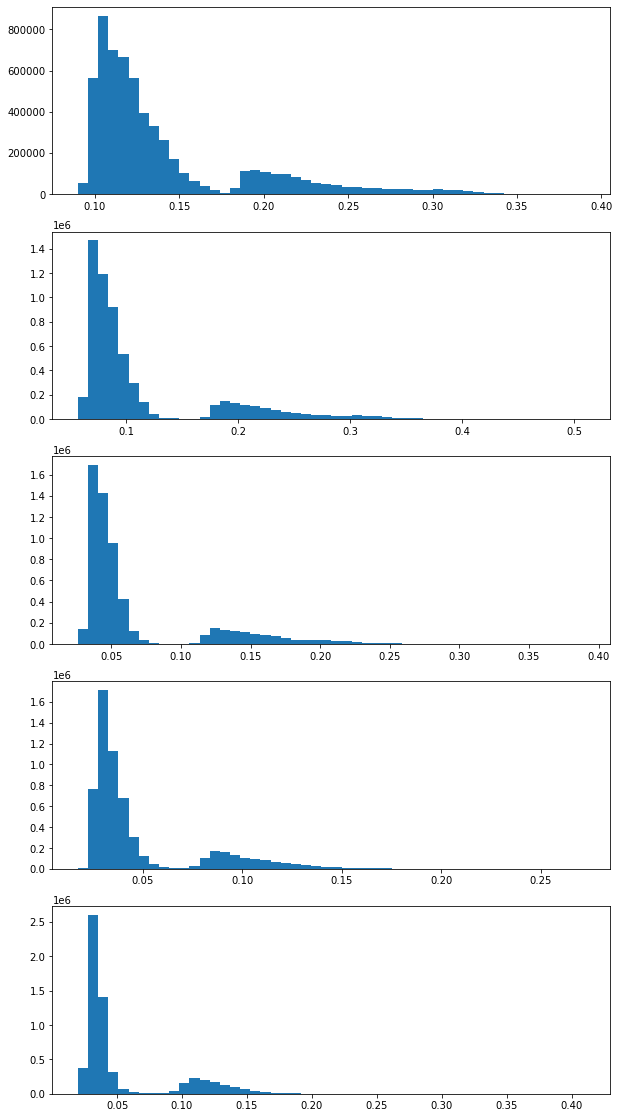

In [35]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(5,1, figsize=(10,20))

for i in range(0,5):
    ax[i].hist(all_sky_imgs[:,i].flatten(), bins=50)
    #ax[i].set_xlim(0,0.060)
    #im = ax[i].imshow(all_imgs[0,i])
    #fig.colorbar(im, ax=ax[i])

In [36]:
def calculate_sky_from_darkest_px(imgs, lowest_percent=0.65, band=4, return_imgs=False, visualize=False, sky=False):
    list_of_spectra = []
    sorted_img_list = []
    dark_idxs = []
    
    for i in range(0,imgs.shape[0]):
        if np.mean(imgs[i,0]) > 0.02 and not sky:
            continue
        # choose the percent to sort
        spectra = []
        #print(imgs.shape)
        num_to_sort = int(imgs[i,band].size * lowest_percent)
        #print('sorting ', num_to_sort)

        # efficiently sort the array
        flat_array = imgs[i,band].flatten()
        flat_array[flat_array == 0 ] = 1 # everything already equal to zero set to 1 to be ignored
        flat_array[flat_array < 0.0001 ] = 1 # take out dark pixels to be ignored
        idx = np.argpartition(flat_array, num_to_sort)[:num_to_sort]
        
        img_sorted = []
        blue_spec = None
        for img_idx in range(0,5):
            sorted_band = imgs[i,img_idx].flatten()
            if return_imgs:
                # add the sorted band to
                img_sorted.append(sorted_band)
            # take the mean of the darkest pixels from each band to add to the spectra
            spectra.append(np.mean(sorted_band[idx]))
            if img_idx == 0:
                blue_spec = np.mean(sorted_band[idx])
        if return_imgs:
            sorted_img_list.append(np.array(img_sorted))
        #if blue_spec <0.02:
        list_of_spectra.append(spectra)
        dark_idxs.append(i)
        
        if visualize:
            plt.hist(flat_array[idx], density=False)
            plt.axvline(x=np.mean(flat_array[idx]), color='red')
            plt.axvline(x=np.median(flat_array[idx]), color='black')
            print(i, np.median(flat_array[idx]))
            
    if return_imgs:
        return(sorted_img_list, idx)
    else:
        return(list_of_spectra, dark_idxs)

0 0.02947998046875
1 0.035186767578125
2 0.10906982421875
3 0.02911376953125
4 0.029541015625


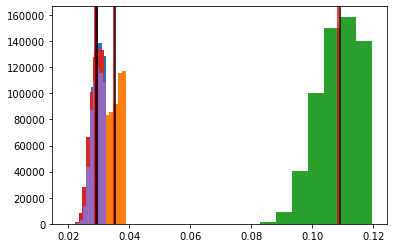

In [37]:
lowest_percent = .5
sky_spectra_red = calculate_sky_from_darkest_px(all_sky_imgs, lowest_percent=lowest_percent, band=4, visualize=True, sky=True)

In [38]:
sky_spectra_red[0]

[[0.10976459891640537,
  0.07439948023858207,
  0.03872315803205604,
  0.028561930886506402,
  0.029286545330044836],
 [0.11167494870692711,
  0.07659087192663583,
  0.04086011668949102,
  0.0322514877717695,
  0.03488065690311332],
 [0.20715475069944775,
  0.20132367368536286,
  0.1345678198662217,
  0.09056162470065206,
  0.10854960830346362],
 [0.10613909375153344,
  0.07205405514571764,
  0.03763231620395355,
  0.027892011205260477,
  0.028896371984698424],
 [0.11091048571758724,
  0.07510929841597214,
  0.03824689171768933,
  0.029030204739940876,
  0.02941997579213089]]

In [39]:
list_of_sky_spectra = sky_spectra_red[0]

In [40]:
red_sky_spectra = []
for spectra in list_of_sky_spectra:
    red_sky_spectra.append(spectra[2])

In [41]:
red_sky_spectra

[0.03872315803205604,
 0.04086011668949102,
 0.1345678198662217,
 0.03763231620395355,
 0.03824689171768933]

In [42]:
sky_spectra = np.median(red_sky_spectra,axis=0)

In [43]:
sky_spectra

0.03872315803205604

### **Convert raw red images to reflectance**
This step uses the irradianceToReflectance scale factor calculated above and corrects for water leaving reflectance based on the median sky_spectra in the red band. The reflectance images can then be used to generate a turbidity shapefile of the average turbidity based on the spectra calculated from ```calculate spectra from darkest pixel```

In [341]:
inputPath = os.path.join('.','data','Sequoia','200717areaaPM01','0016')
outputPath = os.path.join('.','data','Sequoia','200717areaaPM01','0016','Reflectance')


for filename in os.listdir(inputPath):
    if filename.endswith("RED.TIF"):
        imageName = os.path.join(inputPath, filename)
        fullOutputPath = os.path.join(outputPath, filename)
        #im = gdal.Open(imageName)
        flightImageRaw=plt.imread(imageName)
        flightImageMeta = metadata.Metadata(imageName, exiftoolPath=exiftoolPath)
        SequoiaIrradiance, _ = msutils.sequoia_irradiance(flightImageMeta, flightImageRaw)
        SunIrradiance = msutils.GetSunIrradiance(flightImageMeta)
        SequoiaIrradianceCalibrated = SequoiaIrradiance/SunIrradiance
        flightReflectanceImage = SequoiaIrradianceCalibrated * irradianceToReflectance
        water_leaving_reflectance = []
        for spectra in flightReflectanceImage:
            #Ruddick et al. (2009) method for clear sky days 
            water_leaving = np.array(spectra) - np.array(sky_spectra) * (0.0256 + 0.00039 * 5 + 0.000034 * 5 *5)
            water_leaving_reflectance.append(water_leaving)
        water_leaving_img = np.array(water_leaving_reflectance)
        #flightUndistortedReflectance = msutils.correct_lens_distortion_sequoia(flightImageMeta, flightReflectanceImage)
        save_reflectance_imgs(fullOutputPath, water_leaving_img)

#### **Add metadata back to reflectance images**

In [342]:
! exiftool -csv="data/Sequoia/200717areaaPM01/0016/Reflectance/log.csv" -overwrite_original data/Sequoia/200717areaaPM01/0016/Reflectance

    1 directories scanned
  288 image files updated


In [44]:
from GPSPhoto import gpsphoto

outputPath = os.path.join('.','data','Sequoia','200717areaaPM01','0016','Reflectance')
img_metadata_reflectance = []
imgs_reflectance = []
for file in glob.glob(outputPath+ "/*.TIF"):
    imgs_reflectance.append(file)
    img_metadata_reflectance.append(gpsphoto.getGPSData(file))
print(len(imgs_reflectance), imgs_reflectance[0])

209 ./data/Sequoia/200717areaaPM01/0016/Reflectance/IMG_200717_112031_0134_RED.TIF


In [45]:
img_metadata_reflectance[0]

{'Latitude': 34.65665833333333,
 'Longitude': -76.67256666666667,
 'Altitude': 114.2,
 'UTC-Time': '11:20:31',
 'Date': '07/17/2020'}

### **Filter out bright pixels**
Remove the top 10% of brightest pixels to remove man made surfaces (boats) and sun glint. 

In [46]:
reflectance_output = 'data/Sequoia/200717areaaPM01/0016/Reflectance'
reflectance_imgs, reflectance_imgs_metadata = retrieve_imgs_and_metadata(reflectance_output)

Output shape is:  (209, 1, 960, 1280)


In [47]:
reflectance_imgs_metadata[0]

{'Latitude': 34.65665833333333,
 'Longitude': -76.67256666666667,
 'Altitude': 114.2,
 'UTC-Time': '11:20:31',
 'Date': '07/17/2020'}

In [48]:
reflectance_imgs.shape

(209, 1, 960, 1280)

(array([5.15520e+04, 2.20190e+05, 1.89216e+05, 2.04028e+05, 2.29322e+05,
        1.72354e+05, 8.29650e+04, 3.17030e+04, 1.29100e+04, 6.66600e+03,
        4.43800e+03, 3.40000e+03, 2.96400e+03, 2.47900e+03, 2.17700e+03,
        1.73400e+03, 1.37000e+03, 1.11800e+03, 9.54000e+02, 7.68000e+02,
        5.67000e+02, 4.96000e+02, 4.28000e+02, 3.37000e+02, 2.97000e+02,
        2.40000e+02, 2.22000e+02, 2.00000e+02, 2.05000e+02, 1.86000e+02,
        1.60000e+02, 1.64000e+02, 1.40000e+02, 1.47000e+02, 1.36000e+02,
        1.31000e+02, 9.00000e+01, 1.14000e+02, 1.00000e+02, 7.90000e+01,
        7.70000e+01, 8.60000e+01, 9.20000e+01, 5.60000e+01, 9.90000e+02,
        7.26000e+02, 1.90000e+01, 6.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([0.01065063, 0.02356445, 0.03647827, 0.04939209, 0.06230591,
        0.07521973, 0.08813354, 0.10104736, 0.11396118, 0.126875  ,
        0.13978882, 0.15270264, 0.16561646, 0.17853027, 0.19144409,
        0.20435791, 0.21727173, 0.23018555, 0.24309937, 0.256013

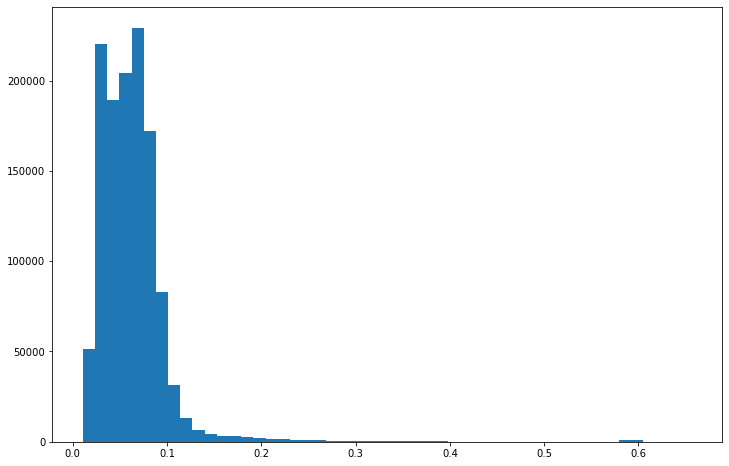

In [49]:
#plot histogram of reflectance values
fig, ax = plt.subplots(figsize=(12,8))

ax.hist(reflectance_imgs[0].flatten(), bins=50,)

In [50]:
reflectance_imgs[1].shape

(1, 960, 1280)

/home/mch87/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]
/home/mch87/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


1105920


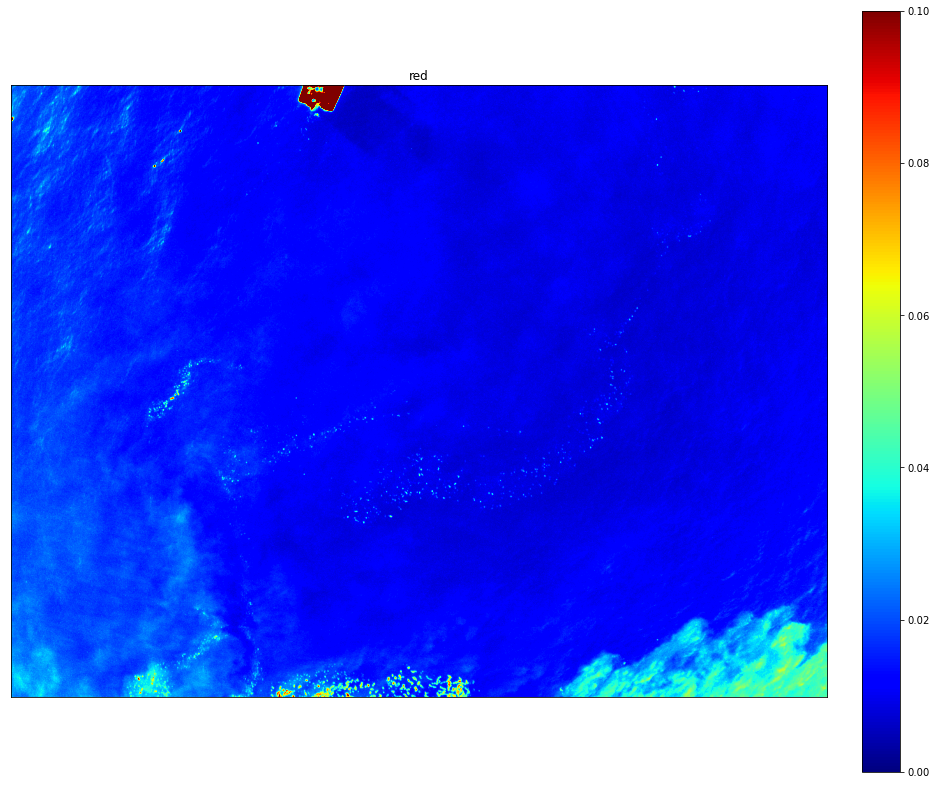

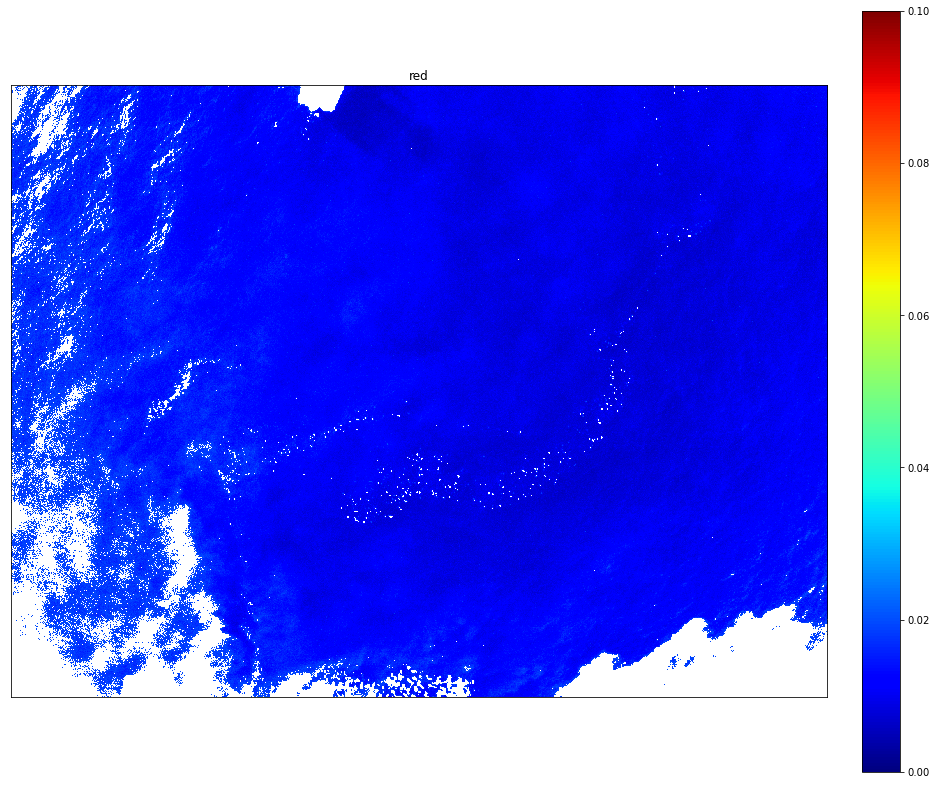

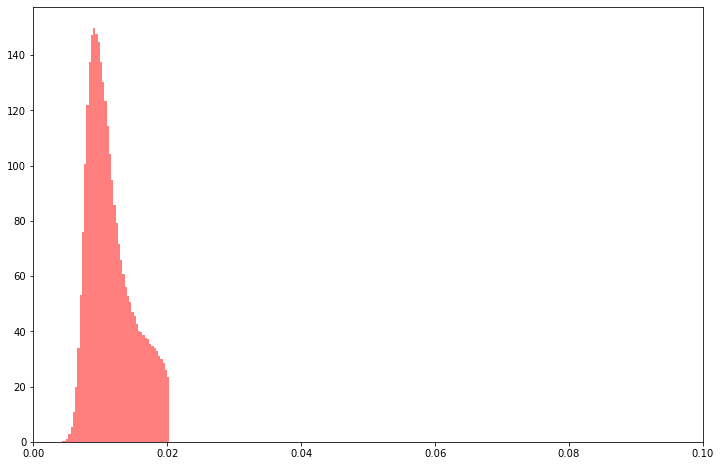

In [53]:
lowest_percent = 0.9
dark_pix_dark = visualize_darkest_pixels(reflectance_imgs[-1], lowest_percent=lowest_percent)

In [217]:
np.nanmean(dark_pix_dark,axis=(1,2))

array([0.00402809])

### **Calculate turbidity from average water leaving spectra in each image**

0 0.003173828125
1 0.00396728515625
2 0.00445556640625
3 0.003387451171875
4 0.005096435546875
5 0.003570556640625
6 0.00311279296875
7 0.003753662109375
8 0.00311279296875
9 0.00396728515625
10 0.003204345703125
11 0.004364013671875
12 0.003509521484375
13 0.00408935546875
14 0.002838134765625
15 0.003204345703125
16 0.003662109375
17 0.0020751953125
18 0.003082275390625
19 0.004364013671875
20 0.003387451171875
21 0.0057373046875
22 0.00323486328125
23 0.004180908203125
24 0.00323486328125
25 0.002899169921875
26 0.00421142578125
27 0.004608154296875
28 0.004852294921875
29 0.03326416015625
30 0.003692626953125
31 0.003631591796875
32 0.003814697265625
33 0.00518798828125
34 0.004119873046875
35 0.003021240234375
36 0.004058837890625
37 0.00384521484375
38 0.003326416015625
39 0.00323486328125
40 0.005584716796875
41 0.0035400390625
42 0.003570556640625
43 0.003509521484375
44 0.003173828125
45 0.003509521484375
46 0.003143310546875
47 0.00555419921875
48 0.003082275390625
49 0.00369

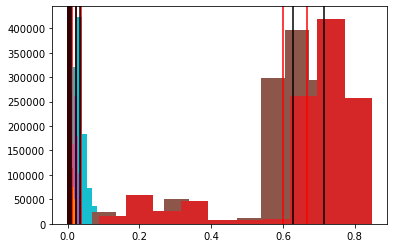

In [218]:
lowest_percent = 0.9

reflectance_spectra_avg, reflectance_idxs_avg = calculate_spectra_from_darkest_px(reflectance_imgs, lowest_percent=lowest_percent, band=0, visualize=True)

In [219]:
reflectance_spectra_avg[0]

[0.0033643888378584825, 0.003173828125, 0.00140380859375, 0.005462646484375]

In [220]:
reflectance_array_avg = np.array(reflectance_spectra_avg)

In [221]:
np.mean(reflectance_array_avg)

0.00880660618468329

In [222]:
reflectance_array_avg.shape

(227, 4)

In [223]:
reflectance_array_avg[0][0]

0.0033643888378584825

In [224]:
a = 254.67
c = 0.1705
turbidity_list_avg = []
for spectra in reflectance_array_avg:
    turbidity = (a * spectra) / (1 - spectra / c)
    turbidity[turbidity < 0] =  0
    #turbidity[turbidity > 100] =  100
    turbidity_list_avg.append(turbidity)
#turbidity_list = np.array(turbidity_list)

In [225]:
turbid_mean_avg = []
turbid_median_avg = []
turbid_min_avg = []
turbid_max_avg = []
for turbid in turbidity_list_avg:
    turbid_mean_avg.append(turbid[0])
    turbid_median_avg.append(turbid[1])
    turbid_min_avg.append(turbid[2])
    turbid_max_avg.append(turbid[3])

In [226]:
spectra_mean_avg = []
spectra_median_avg = []
spectra_min_avg = []
spectra_max_avg = []
for spectra in reflectance_spectra_avg:
    spectra_mean_avg.append(spectra[0])
    spectra_median_avg.append(spectra[1])
    spectra_min_avg.append(spectra[2])
    spectra_max_avg.append(spectra[3])

In [227]:
turbid_mean_avg = np.array(turbid_mean_avg)
turbid_median_avg = np.array(turbid_median_avg)
turbid_min_avg = np.array(turbid_min_avg)
turbid_max_avg = np.array(turbid_max_avg)

In [228]:
turbid_mean_avg.shape

(227,)

In [229]:
spectra_mean_avg = np.array(spectra_mean_avg)
spectra_median_avg = np.array(spectra_median_avg)
spectra_min_avg = np.array(spectra_min_avg)
spectra_max_avg = np.array(spectra_max_avg)

In [230]:
spectra_mean_avg.shape

(227,)

In [231]:
np.nanmax(turbid_mean_avg), np.nanmedian(turbid_mean_avg), np.nanmean(turbid_mean_avg)

(56.77658417104912, 4.711914707258299, 5.202900234276543)

In [232]:
np.nanmax(spectra_mean_avg), np.nanmedian(spectra_mean_avg), np.nanmean(spectra_mean_avg)

(0.667075878188566, 0.0038116304686775914, 0.009680388636034917)

### **Export per image spectra and turbidity values as shapefiles with image metadata**

In [233]:
from datetime import datetime
import pandas as pd
import geopandas as gpd

def convert_to_df(turbidity_mean, turbidity_median, turbidity_min, turbidity_max, spectra_mean, reflectance_imgs_metadata):
    dates = []
    for im in reflectance_imgs_metadata:
        date_time_str = im['Date'] + ' ' + im['UTC-Time']
        
        date_time_obj = datetime.strptime(date_time_str, '%m/%d/%Y %H:%M:%S')
        date_time = date_time_obj - timedelta(hours=4)
        dates.append(date_time)
    lons = []
    lats = []
    for im in reflectance_imgs_metadata:
        lons.append(im['Longitude'])
        lats.append(im['Latitude'])
        
    #y = np.arange(turbidity_list.shape[0],dtype=int)
    #x = [data for data in turbidity_list]  
    turbidity_df = pd.DataFrame(
    {'mean': turbidity_mean,
    'median': turbidity_median,
    'min': turbidity_min,
    'max': turbidity_max,
    'spectra': spectra_mean,
    'Latitude': lats,
    'Longitude': lons,
    'time' : dates})
    
    turbidity_gdf = gpd.GeoDataFrame(
        turbidity_df, geometry=gpd.points_from_xy(turbidity_df.Longitude, turbidity_df.Latitude))
    return(turbidity_gdf)

In [234]:
gdf = convert_to_df(turbid_mean_avg, turbid_median_avg, turbid_min_avg, turbid_max_avg, spectra_mean_avg, [reflectance_imgs_metadata[i] for i in reflectance_idxs_avg])

gdf.head()

mean    median       min       max   spectra   Latitude  Longitude  \
0  4.213235  3.970872  1.741197  6.912254  0.003364  34.654953 -76.670500   
1  5.157428  4.983026  0.376505  8.991221  0.004103  34.658697 -76.671103   
2  5.723988  5.609839  2.429037  8.548686  0.004544  34.661839 -76.669119   
3  4.271384  4.242597  1.779314  5.806340  0.003410  34.656108 -76.668525   
4  6.316157  6.437142  2.161106  9.637571  0.005003  34.658939 -76.669833   

                 time                    geometry  
0 2020-07-17 08:52:57  POINT (-76.67050 34.65495)  
1 2020-07-17 08:49:33  POINT (-76.67110 34.65870)  
2 2020-07-17 08:57:41  POINT (-76.66912 34.66184)  
3 2020-07-17 09:01:01  POINT (-76.66853 34.65611)  
4 2020-07-17 08:55:49  POINT (-76.66983 34.65894)

<AxesSubplot:>

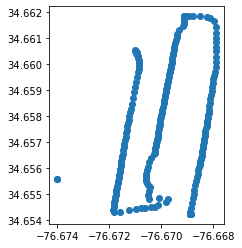

In [235]:
gdf.plot()

In [236]:
gdf.time = gdf.time.astype(str)
gdf.to_file('data/Sequoia/200717areaaPM01/0016/Turbidity/turbidity_200717_flight01.shp')

### **Inspect full images**

/home/mch87/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]
/home/mch87/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


1105920


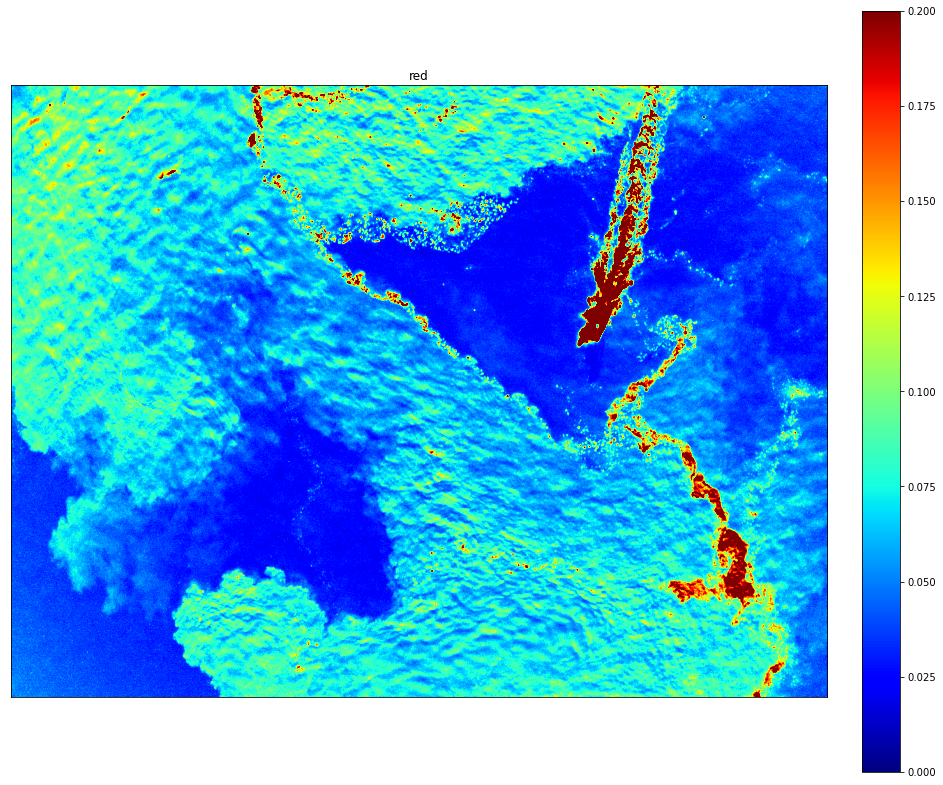

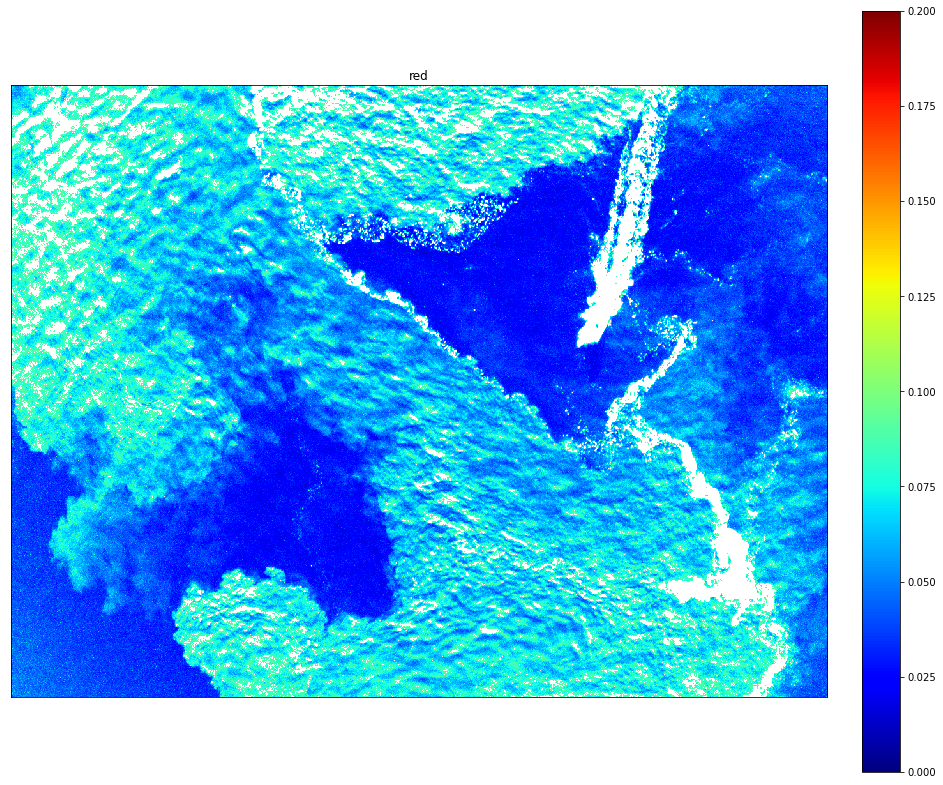

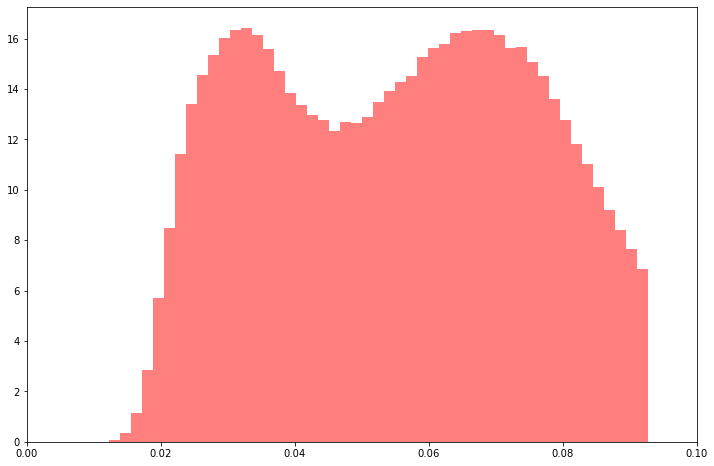

In [57]:
lowest_percent = 0.9
dark_pix_dark = visualize_darkest_pixels(reflectance_imgs[0], lowest_percent=lowest_percent)

In [58]:
dark_pix_dark.shape

(1, 960, 1280)

In [59]:
full_img = turbidity_img(dark_pix_dark)

In [60]:
full_img.shape

(960, 1280)

In [61]:
np.nanmax(full_img), np.nanmedian(full_img), np.nanmean(full_img)

(51.86444620737927, 20.99608197440004, 22.57962018223971)

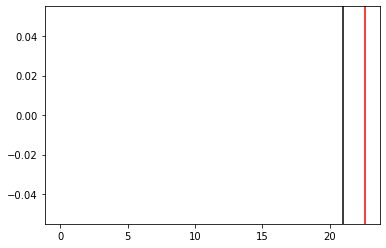

In [64]:
plt.hist(full_img.flatten(), range=(0,1), bins=50)
plt.axvline(np.nanmedian(full_img), c='black')
plt.axvline(np.nanmean(full_img), c='red')
plt.show()

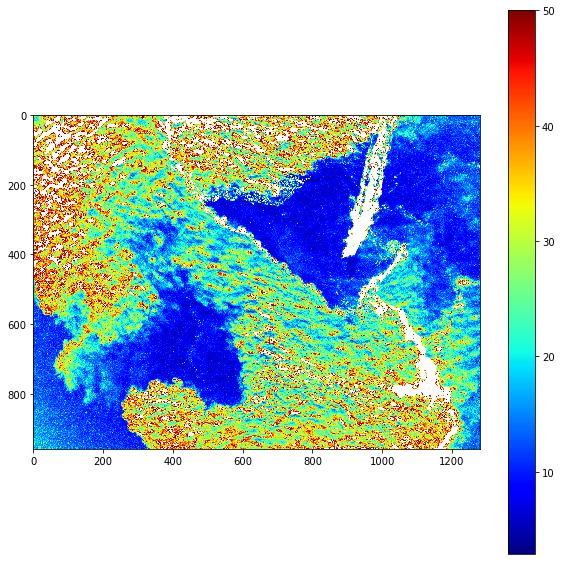

In [66]:
import matplotlib
fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(full_img, interpolation='nearest', cmap='jet', vmax=50)
#current_cmap = matplotlib.cm.get_cmap()
#current_cmap.set_bad(color='yellow')

fig.colorbar(im)

### **Convert reflectance images to turbidity**

In [67]:
from GPSPhoto import gpsphoto

outputPath = os.path.join('.','data','Sequoia','200717areaaPM01','0016')
img_metadata = []
imgs = []
for file in glob.glob(outputPath+ "/*.TIF"):
    imgs.append(file)
    img_metadata.append(gpsphoto.getGPSData(file))
print(len(imgs), imgs[0])

209 ./data/Sequoia/200717areaaPM01/0016/IMG_200717_112031_0134_RED.TIF


In [293]:
reflectance_output = 'data/Sequoia/200717areaaPM01/0016/Reflectance'
reflectance_imgs, reflectance_imgs_metadata = retrieve_imgs_and_metadata(reflectance_output)

Output shape is:  (290, 1, 960, 1280)


In [294]:
import rasterio
from rasterio.warp import calculate_default_transform

#inputPath = os.path.join('.','data','Sequoia','200717areaaPM06','0001')
outputPath = os.path.join('.','data','Sequoia','200717areaaPM01','0016','Turbidity')

a = 254.67
c = 0.1705
count = 0
lowest_percent = 0.9
f = 3.98
sensor_size = (4.8, 3.6)
image_size = (1280,960)

for im in reflectance_imgs:
    dark_pix = remove_bright_pix(im, lowest_percent=lowest_percent, band=0)
    dark_pix_dark = dark_pix.reshape(1,im.shape[1],im.shape[2])
    full_img = turbidity_img(dark_pix_dark)

    lat = reflectance_imgs_metadata[count]['Latitude']
    lon = reflectance_imgs_metadata[count]['Longitude']
    alt = reflectance_imgs_metadata[count]['Altitude']
    
    #tilt_deg=pitch+sensor_offset
    #roll_deg=roll
    #heading_deg=-yaw
    cam = ct.Camera(ct.RectilinearProjection(focallength_mm=f,
                                         sensor=sensor_size,
                                         image=image_size),
                    ct.SpatialOrientation(elevation_m=alt,
                                         tilt_deg=0,
                                         roll_deg= -0.5,
                                         heading_deg=0))
    cam.setGPSpos(lat, lon, alt)
    coords = np.array([cam.gpsFromImage([0 , 0]), \
                      cam.gpsFromImage([image_size[0]-1 , 0]), \
                      cam.gpsFromImage([image_size[0]-1, image_size[1]-1]), \
                      cam.gpsFromImage([0 , image_size[1]-1])])

    imageName = imgs[count]
    fullOutputPath = os.path.join(outputPath, str(count)+ ".tif")
    count += 1
    array2raster(fullOutputPath, imageName, full_img, coords)

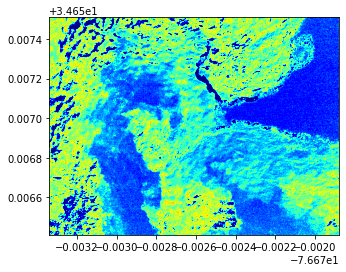

<AxesSubplot:>

In [112]:
from rasterio.plot import show 
src = rasterio.open("data/Sequoia/200717areaaPM01/0016/Turbidity/NIR_Test/3.tif")
show(src,clim=(0,100),cmap='jet')

In [95]:
with rasterio.open("data/Sequoia/200717areaaPM01/0016/Turbidity/208.tif") as src:
    profile = src.profile
print(profile)

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 1280, 'height': 960, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(4.824283980975659e-07, 0.0, -76.67245055287998,
       0.0, -4.824283980975659e-07, 34.65464697583), 'tiled': False, 'interleave': 'band'}


In [239]:
import shutil
from osgeo import gdal, osr

orig_fn = 'example_200717_PM01.tif'
output_fn = 'output2.tif'

# Create a copy of the original file and save it as the output filename:
shutil.copy(orig_fn, output_fn)
# Open the output file for writing for writing:
ds = gdal.Open(output_fn, gdal.GA_Update)
# Set spatial reference:
sr = osr.SpatialReference()
sr.ImportFromEPSG(4326) #2193 refers to the NZTM2000, but can use any desired projection

# Enter the GCPs
#   Format: [map x-coordinate(longitude)], [map y-coordinate (latitude)], [elevation],
#   [image column index(x)], [image row index (y)]
gcps = [gdal.GCP(coords[0,0], coords[0,1], 0, 0, 0),
        gdal.GCP(coords[1,0], coords[1,1], 0, 0, image_size[0]-1),
        gdal.GCP(coords[2,0], coords[2,1], 0, image_size[1]-1, image_size[0]-1),
        gdal.GCP(coords[3,0], coords[3,1], 0, image_size[1]-1, 0)]

# Apply the GCPs to the open output file:
ds.SetGCPs(gcps, sr.ExportToWkt())

# Close the output file in order to be able to work with it in other programs:
ds = None

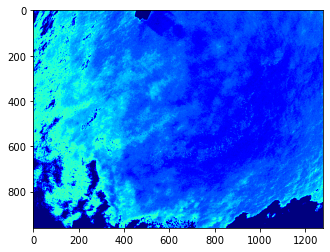

<AxesSubplot:>

In [240]:
from rasterio.plot import show
src = rasterio.open("output2.tif")
show(src,clim=(0,10),cmap='jet')